In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.envs.darkroom import DarkroomEnv

# Load Model

In [3]:
engram_dir = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/"
wandb_project = "darkroom_simple"

env_name = "darkroom_dim5_corr0.0_state_dim10_envs900000_H200_explore"
model_name = "transformer_end_query_embd256_layer4_head4_lr0.0001_drop0_initseed0_batch1024"

env_name = "darkroom_dim5_corr0.0_state_dim10_envs900000_H200_explore"
model_name = "transformer_end_query_embd512_layer4_head4_lr0.0001_drop0_initseed0_batch1024"

env_name = "darkroom_dim5_corr0.25_state_dim10_envs900000_H200_explore"
model_name = "transformer_end_query_embd512_layer4_head4_lr0.0001_drop0.0_initseed0_batch1024"

env_name = "darkroom_dim5_corr0.25_state_dim10_envs900000_H200_explore"
model_name = "transformer_end_query_embd512_layer3_head4_lr0.0001_drop0.0_initseed0_batch1024"

model_path = os.path.join(engram_dir, wandb_project, env_name, "models", model_name)
ckpt_name = find_ckpt_file(model_path, "best")
print(ckpt_name)
path_to_pkl = os.path.join(model_path, ckpt_name)
eval_dset_path = f"/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/{wandb_project}/{env_name}/datasets/eval.pkl"

epoch=8-val_loss=0.857135.ckpt


In [4]:
# Extract parameters using regex
import re

n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))

# Extract correlation and state_dim from eval dataset path
state_dim = int(re.search(r'state_dim(\d+)', eval_dset_path).group(1))
maze_dim = int(re.search(r'_dim(\d+)_corr', eval_dset_path).group(1))
node_encoding_corr = float(re.search(r'corr(\d*\.?\d*)', eval_dset_path).group(1))

model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": state_dim,
    "action_dim": 5,
    "dropout": dropout,
    "train_on_last_pred_only": False,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
    "linear_attention": False,
}

In [5]:
from src.models.transformer_end_query import Transformer
model_config['initialization_seed'] = 0
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')

# Load Dataset and Create Environment

In [6]:
n_eval_envs = 200

is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
    n_eval_envs = min(n_eval_envs, len(traj_indices))
    random.seed(0)
    traj_indices = random.sample(traj_indices, n_eval_envs)
    random.seed()
    eval_trajs = [eval_trajs[i] for i in traj_indices]
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
    n_eval_envs = min(n_eval_envs, len(eval_trajs))
    random.seed(0)
    eval_trajs = random.sample(eval_trajs, n_eval_envs)
    random.seed()


In [7]:
seq_length = 150

In [8]:
def run_model(traj, model, seq_length=1200, start_idx=800):
    hidden_states = []

    batch = {
        'context_states': convert_to_tensor([np.array(traj['context_states'])]),
        'context_actions': convert_to_tensor([np.array(traj['context_actions'])]),
        'context_next_states': convert_to_tensor([np.array(traj['context_next_states'])]),
        'context_rewards': convert_to_tensor([np.array(traj['context_rewards'])[:, None]]),
        'query_states': convert_to_tensor([np.array(traj['query_state'])]),  # Ignored
        }
    batch['zeros'] = torch.zeros(1, 10 ** 2 + 4 + 1).float()
    for k in batch.keys():
        if 'context' in k:
            batch[k] = batch[k][:,:seq_length]
        batch[k] = batch[k].to(model.device)
    model.save_activations = True
    with torch.no_grad():
        out = model(batch)
    _hidden_states = model.activations['hidden_states'][1:] # Tuple over layers of (1, seq, dim)
    state_features = batch['context_states'][0][start_idx:].to('cpu').numpy()
    next_state_features = batch['context_next_states'][0][start_idx:].to('cpu').numpy()
    actions = batch['context_actions'][0].argmax(dim=1)[start_idx:].to('cpu').numpy()
    for i_layer in range(model.n_layer):
        hidden_states.append(_hidden_states[i_layer][0,start_idx:-1])
    return hidden_states, state_features, next_state_features, actions

# Across context decoding

In [9]:
def get_subtree_location(pos, subtree):
    x, y = pos
    midpt = maze_dim//2
    if subtree == 'half':
        return 0 if x < midpt else 1
    elif subtree == 'quarter':
        if x < midpt:
            if y < midpt:
                return 0
            else:
                return 1
        else:
            if y < midpt:
                return 2
            else:
                return 3
    

In [10]:
def make_train_test_matrices():
    X = [[] for _ in range(model.n_layer)]
    Ys_dict = {
        "dist_from_goal": [],
        "angle_from_goal": [],
        "value": [],
        "node_identity": [],
        "maze_half": [],
        "maze_quarter": [],
        'is_goal': [],
        'same_half_as_goal': [],
        'same_quarter_as_goal': [],
        'opt_action': [],
        'state_feature': [],
        'next_state_feature': [],
        "inverse_action": [],
        "action": []
    }
    for i_eval in range(n_eval_envs):
        onehot_env = np.zeros(n_eval_envs)
        onehot_env[i_eval] = 1
        traj = eval_trajs[i_eval]
        first_reward = np.argwhere(np.array(traj['context_rewards'])>0)
        if (first_reward.size == 0) or (first_reward[0] > seq_length):
            continue
        start_idx = first_reward[0].item()

        env_config = {
            'maze_dim': maze_dim,
            'horizon': 200,
            'state_dim': state_dim,
            'node_encoding_corr': node_encoding_corr,
            'initialization_seed': np.array(traj['initialization_seed']).item(),
            'goal': np.array(traj['goal'])
        }
        env = DarkroomEnv(**env_config)
        opt_action_map, dist_from_goal = env.make_opt_action_dict()

        hidden_states, state_features, next_state_features, actions = run_model(traj, model, seq_length, start_idx)
        goal_node = env.node_map_encoding_to_pos[tuple(env.goal.tolist())]
        seen_combos = set()
        for state_idx in reversed(range(len(state_features))):
            state_feature = state_features[state_idx]
            next_state_feature = next_state_features[state_idx]
            state_feature_tuple = tuple(state_feature.tolist())
            next_state_feature_tuple = tuple(next_state_feature.tolist())
            action = actions[state_idx]
            combo = tuple(state_feature.tolist() + next_state_feature.tolist())
            if combo in seen_combos:
                continue
            seen_combos.add(combo)
            d = dist_from_goal[next_state_feature_tuple]
            node_identity = env.node_map_encoding_to_pos[next_state_feature_tuple]
            maze_half = get_subtree_location(node_identity, 'half')
            maze_quarter = get_subtree_location(node_identity, 'quarter')
            if action == 0:
                inverse_action = 2
            elif action == 1:
                inverse_action = 3
            elif action == 2:
                inverse_action = 0
            elif action == 3:
                inverse_action = 1
            else:
                inverse_action = 4
            
            Ys_dict["dist_from_goal"].append(d)
            Ys_dict["angle_from_goal"].append(
                np.arctan2(goal_node[1] - node_identity[1], goal_node[0] - node_identity[0])
                )
            Ys_dict["value"].append(0.7**d)
            Ys_dict["node_identity"].append(node_identity)
            Ys_dict["maze_half"].append(maze_half)
            Ys_dict["maze_quarter"].append(maze_quarter)
            Ys_dict["is_goal"].append(state_feature_tuple == tuple(env.goal.tolist()))
            Ys_dict["same_half_as_goal"].append(maze_half == get_subtree_location(goal_node, 'half'))
            Ys_dict["same_quarter_as_goal"].append(maze_quarter == get_subtree_location(goal_node, 'quarter'))
            Ys_dict["opt_action"].append(opt_action_map[state_feature_tuple])
            Ys_dict["state_feature"].append(state_feature)
            Ys_dict["next_state_feature"].append(next_state_feature)
            Ys_dict["inverse_action"].append(inverse_action)
            Ys_dict["action"].append(action)
            
            for layer in range(model.n_layer):
                hidden_state = hidden_states[layer][state_idx].to('cpu').numpy()
                hidden_state = np.concatenate([hidden_state, onehot_env])
                X[layer].append(hidden_state)
        torch.cuda.empty_cache()

    test_size = 0.1
    test_start_idx = int(len(X[0])*(1-test_size))
    all_indices = np.arange(len(X[0]))
    np.random.shuffle(all_indices)
    train_indices = all_indices[:test_start_idx]
    test_indices = all_indices[test_start_idx:]

    X_train = [[] for _ in range(model.n_layer)]
    X_test = [[] for _ in range(model.n_layer)]
    Ys_dict_train_test = {key: {'Y_train': [], 'Y_test': []} for key in Ys_dict}
    # Use same indices for all layers to keep corresponding samples together
    for layer, layer_data in enumerate(X):
        X_train[layer] = [layer_data[i] for i in train_indices]
        X_test[layer] = [layer_data[i] for i in test_indices]
    for key in Ys_dict:
        Ys_dict_train_test[key]['Y_train'] = [Ys_dict[key][i] for i in train_indices]
        Ys_dict_train_test[key]['Y_test'] = [Ys_dict[key][i] for i in test_indices]
    return X_train, X_test, Ys_dict_train_test

In [11]:
import warnings

from sklearn.metrics import balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

def fit_and_evaluate_regression(X_train, Y_train, X_test, Y_test, print_scores=True, make_plot=True):
    from joblib import Parallel, delayed
    from sklearn.model_selection import KFold
    from sklearn.linear_model import Ridge
    
    X_train_np = [np.array([_x for _x in x]) for x in X_train]
    X_test_np = [np.array([_x for _x in x]) for x in X_test]
    Y_train_np = np.array(Y_train)
    Y_test_np = np.array(Y_test)

    alphas = np.logspace(0, 4, 10)
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    def evaluate_fold(X, y, train_idx, val_idx, alpha):
        # Train on this fold
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=alpha))
        ])
        pipeline.fit(X[train_idx], y[train_idx])
        # Get validation score
        val_score = pipeline.score(X[val_idx], y[val_idx])
        return val_score

    pipelines = []
    test_scores = []
    
    for layer in range(len(X_train)-1):
        # Parallel CV for each alpha
        cv_scores = {alpha: [] for alpha in alphas}
        for alpha in alphas:
            scores = Parallel(n_jobs=-1)(
                delayed(evaluate_fold)(
                    X_train_np[layer], Y_train_np, 
                    train_idx, val_idx, alpha
                )
                for train_idx, val_idx in kf.split(X_train_np[layer])
            )
            cv_scores[alpha] = np.mean(scores)
        
        # Find best alpha
        best_alpha = max(cv_scores.items(), key=lambda x: x[1])[0]
        
        # Train final model with best alpha
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=best_alpha))
        ])
        pipeline.fit(X_train_np[layer], Y_train_np)
        
        train_score = pipeline.score(X_train_np[layer], Y_train_np)
        test_score = pipeline.score(X_test_np[layer], Y_test_np)
        
        pipelines.append(pipeline)
        test_scores.append(test_score)
        
        if print_scores:
            print(f"Layer {layer}:")
            print(f"Best alpha: {best_alpha:.3f}")
            print(f"Train R2: {train_score:.3f}")
            print(f"Test R2: {test_score:.3f}")
            print()

        if make_plot:
            y_pred = pipeline.predict(X_test_np[layer])
            plt.figure(figsize=(3, 3))
            plt.scatter(Y_test_np, y_pred, alpha=0.5)
            plt.plot([Y_test_np.min(), Y_test_np.max()], [Y_test_np.min(), Y_test_np.max()], 'r--')
            plt.xlabel('True Values')
            plt.ylabel('Predictions')
            plt.title(f'Layer {layer}: True vs Predicted Values')
            plt.tight_layout()
            plt.show()
            
    return pipelines, test_scores

def fit_and_evaluate_classification(X_train, Y_train, X_test, Y_test, print_scores=True, make_plot=True):
    import warnings
    from sklearn.exceptions import ConvergenceWarning
    warnings.filterwarnings('ignore', category=ConvergenceWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
    from joblib import Parallel, delayed
    from sklearn.model_selection import KFold
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

    X_train_np = [np.array([_x for _x in x]) for x in X_train]
    X_test_np = [np.array([_x for _x in x]) for x in X_test]
    Y_train_np = np.array(Y_train)
    Y_test_np = np.array(Y_test)

    Cs = np.logspace(-3, 3, 10)
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    def evaluate_fold(X, y, train_idx, val_idx, C):
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(
                C=C, 
                max_iter=3000,
                class_weight='balanced',  # Add class weighting
                random_state=42
            ))
        ])
        pipeline.fit(X[train_idx], y[train_idx])
        y_val_pred = pipeline.predict(X[val_idx])
        # Use balanced accuracy score instead of regular accuracy
        return balanced_accuracy_score(y[val_idx], y_val_pred)

    pipelines = []
    test_scores = []
    
    for layer in range(len(X_train)-1):
        # Parallel CV for each C value
        cv_scores = {C: [] for C in Cs}
        for C in Cs:
            scores = Parallel(n_jobs=-1)(
                delayed(evaluate_fold)(
                    X_train_np[layer], Y_train_np, 
                    train_idx, val_idx, C
                )
                for train_idx, val_idx in kf.split(X_train_np[layer])
            )
            cv_scores[C] = np.mean(scores)
        
        # Find best C
        best_C = max(cv_scores.items(), key=lambda x: x[1])[0]
        
        # Train final model with best C
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(
                C=best_C, 
                max_iter=3000,
                class_weight='balanced',  # Add class weighting
                random_state=42
            ))
        ])
        pipeline.fit(X_train_np[layer], Y_train_np)
        
        y_train_pred = pipeline.predict(X_train_np[layer])
        y_test_pred = pipeline.predict(X_test_np[layer])
        
        # Use balanced metrics
        train_accuracy = balanced_accuracy_score(Y_train_np, y_train_pred)
        test_accuracy = balanced_accuracy_score(Y_test_np, y_test_pred)
        train_f1 = f1_score(Y_train_np, y_train_pred, average='weighted')
        test_f1 = f1_score(Y_test_np, y_test_pred, average='weighted')

        if print_scores:
            print(f"Layer {layer}:")
            print(f"Best C: {best_C:.3f}")
            print(f"Train Balanced Accuracy: {train_accuracy:.3f}")
            print(f"Test Balanced Accuracy: {test_accuracy:.3f}")
            print(f"Train Weighted F1: {train_f1:.3f}")
            print(f"Test Weighted F1: {test_f1:.3f}")
            # Add class distribution information
            print("Class distribution:")
            for cls in np.unique(Y_train_np):
                print(f"Class {cls}: {np.sum(Y_train_np == cls)} samples")
            print()

        if make_plot:
            # Add confusion matrix visualization
            y_test_pred = pipeline.predict(X_test_np[layer])
            cm = confusion_matrix(Y_test_np, y_test_pred)
            plt.figure(figsize=(3, 3))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Layer {layer}: Confusion Matrix')
            plt.tight_layout()
            plt.show()
            
            print()

    return pipelines, test_scores

In [16]:
def fit_and_evaluate_circular_regression(X_train, Y_train, X_test, Y_test, print_scores=True, make_plot=True, figname=None):
    from joblib import Parallel, delayed
    from sklearn.model_selection import KFold
    from sklearn.linear_model import Ridge
    import numpy as np
    
    # Convert angles to sine and cosine components
    def angle_to_sin_cos(angles):
        return np.column_stack((np.sin(angles), np.cos(angles)))
    
    # Convert sine and cosine predictions back to angles
    def sin_cos_to_angle(sin_vals, cos_vals):
        return np.arctan2(sin_vals, cos_vals)
    
    X_train_np = [np.array([_x for _x in x]) for x in X_train]
    X_test_np = [np.array([_x for _x in x]) for x in X_test]
    Y_train_np = np.array(Y_train)
    Y_test_np = np.array(Y_test)
    
    # Convert target angles to sin/cos components
    Y_train_sin = np.sin(Y_train_np)
    Y_train_cos = np.cos(Y_train_np)
    Y_test_sin = np.sin(Y_test_np)
    Y_test_cos = np.cos(Y_test_np)

    alphas = np.logspace(0, 4, 10)
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    def evaluate_fold(X, y_sin, y_cos, train_idx, val_idx, alpha):
        # Train sin model
        sin_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=alpha))
        ])
        sin_pipeline.fit(X[train_idx], y_sin[train_idx])
        
        # Train cos model
        cos_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=alpha))
        ])
        cos_pipeline.fit(X[train_idx], y_cos[train_idx])
        
        # Predict and convert back to angles
        sin_pred = sin_pipeline.predict(X[val_idx])
        cos_pred = cos_pipeline.predict(X[val_idx])
        angle_pred = sin_cos_to_angle(sin_pred, cos_pred)
        
        # Calculate circular error
        true_angles = np.arctan2(y_sin[val_idx], y_cos[val_idx])
        errors = np.abs(np.arctan2(np.sin(angle_pred - true_angles), np.cos(angle_pred - true_angles)))
        mean_circular_error = np.mean(errors)
        
        # Return negative error as score (higher is better)
        return -mean_circular_error

    pipelines = []
    test_scores = []
    
    for layer in range(len(X_train)-1):
        # Parallel CV for each alpha
        cv_scores = {alpha: [] for alpha in alphas}
        for alpha in alphas:
            scores = Parallel(n_jobs=-1)(
                delayed(evaluate_fold)(
                    X_train_np[layer], Y_train_sin, Y_train_cos, 
                    train_idx, val_idx, alpha
                )
                for train_idx, val_idx in kf.split(X_train_np[layer])
            )
            cv_scores[alpha] = np.mean(scores)
        
        # Find best alpha (lowest error)
        best_alpha = max(cv_scores.items(), key=lambda x: x[1])[0]
        
        # Train final sin model with best alpha
        sin_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=best_alpha))
        ])
        sin_pipeline.fit(X_train_np[layer], Y_train_sin)
        
        # Train final cos model with best alpha
        cos_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=best_alpha))
        ])
        cos_pipeline.fit(X_train_np[layer], Y_train_cos)
        
        # Evaluate on train set
        train_sin_pred = sin_pipeline.predict(X_train_np[layer])
        train_cos_pred = cos_pipeline.predict(X_train_np[layer])
        train_angle_pred = sin_cos_to_angle(train_sin_pred, train_cos_pred)
        train_errors = np.abs(np.arctan2(np.sin(train_angle_pred - Y_train_np), np.cos(train_angle_pred - Y_train_np)))
        train_mean_error = np.mean(train_errors)
        
        # Evaluate on test set
        test_sin_pred = sin_pipeline.predict(X_test_np[layer])
        test_cos_pred = cos_pipeline.predict(X_test_np[layer])
        test_angle_pred = sin_cos_to_angle(test_sin_pred, test_cos_pred)
        test_errors = np.abs(np.arctan2(np.sin(test_angle_pred - Y_test_np), np.cos(test_angle_pred - Y_test_np)))
        test_mean_error = np.mean(test_errors)
        
        pipelines.append((sin_pipeline, cos_pipeline))
        test_scores.append(-test_mean_error)  # Store negative error as score
        
        if print_scores:
            print(f"Layer {layer}:")
            print(f"Best alpha: {best_alpha:.3f}")
            print(f"Train mean circular error: {train_mean_error:.3f} radians ({np.degrees(train_mean_error):.1f}°)")
            print(f"Test mean circular error: {test_mean_error:.3f} radians ({np.degrees(test_mean_error):.1f}°)")
            print()

        if make_plot:
            # Also show a scatter plot of true vs predicted
            plt.figure(figsize=(3, 3))
            plt.scatter(Y_test_np, test_angle_pred, alpha=0.5)
            plt.xlabel('True Angle')
            plt.ylabel('Predicted Angle')
            plt.title(f'Layer {layer}: Angle to Goal')
            plt.xticks([-np.pi, 0, np.pi], [r'$-\pi$', '0', r'$\pi$'])
            plt.yticks([-np.pi, 0, np.pi], [r'$-\pi$', '0', r'$\pi$'])
            plt.tight_layout()
            if figname is not None:
                plt.savefig('figs/' + f'buffer_decoding_L{layer}' + figname, dpi=300)
            plt.show()
            
    return pipelines, test_scores

In [17]:
from src.models.transformer_end_query import Transformer
model_config['initialization_seed'] = 0
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')

In [14]:
X_train, X_test, Ys_dict = make_train_test_matrices()

`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Layer 0:
Best alpha: 21.544
Train mean circular error: 0.320 radians (18.3°)
Test mean circular error: 0.391 radians (22.4°)



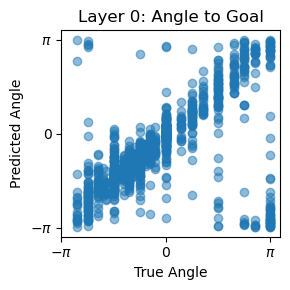

Layer 1:
Best alpha: 59.948
Train mean circular error: 0.193 radians (11.1°)
Test mean circular error: 0.220 radians (12.6°)



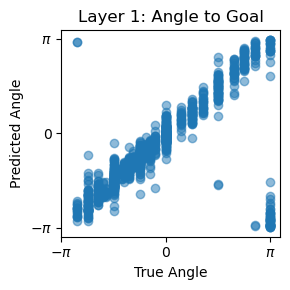

In [19]:
pipeline, test_score = fit_and_evaluate_circular_regression(
    X_train, 
    Ys_dict["angle_from_goal"]["Y_train"], 
    X_test, 
    Ys_dict["angle_from_goal"]["Y_test"],
    figname='goal_angle.svg'
)

Layer 0:
Best alpha: 59.948
Train R2: 0.682
Test R2: 0.595



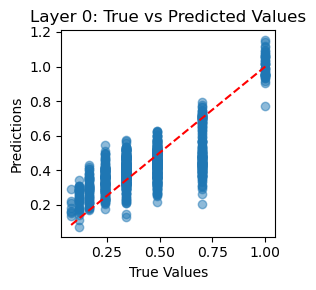

Layer 1:
Best alpha: 21.544
Train R2: 0.779
Test R2: 0.729



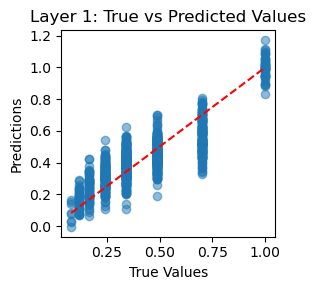

In [33]:
pipeline, test_score = fit_and_evaluate_regression(X_train, Ys_dict["value"]["Y_train"], X_test, Ys_dict["value"]["Y_test"])

Layer 0:
Best C: 0.022
Train Balanced Accuracy: 0.674
Test Balanced Accuracy: 0.503
Train Weighted F1: 0.523
Test Weighted F1: 0.414
Class distribution:
Class 0: 531 samples
Class 1: 1644 samples
Class 2: 2660 samples
Class 3: 2554 samples
Class 4: 1455 samples
Class 5: 617 samples
Class 6: 299 samples
Class 7: 98 samples



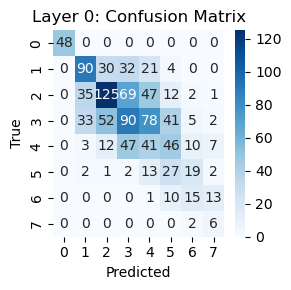


Layer 1:
Best C: 0.100
Train Balanced Accuracy: 0.799
Test Balanced Accuracy: 0.590
Train Weighted F1: 0.663
Test Weighted F1: 0.531
Class distribution:
Class 0: 531 samples
Class 1: 1644 samples
Class 2: 2660 samples
Class 3: 2554 samples
Class 4: 1455 samples
Class 5: 617 samples
Class 6: 299 samples
Class 7: 98 samples



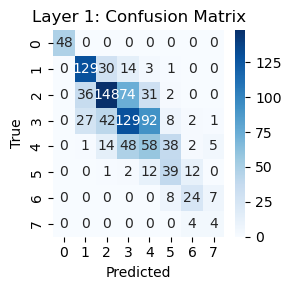

In [35]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["dist_from_goal"]["Y_train"], X_test, Ys_dict["dist_from_goal"]["Y_test"])

In [36]:
_Y_train = [f"{y[0]},{y[1]}" for y in Ys_dict["node_identity"]["Y_train"]]
_Y_test = [f"{y[0]},{y[1]}" for y in Ys_dict["node_identity"]["Y_test"]]
pipeline, test_score = fit_and_evaluate_classification(
    X_train, _Y_train, X_test, _Y_test, make_plot=False)

Layer 0:
Best C: 0.464
Train Balanced Accuracy: 0.809
Test Balanced Accuracy: 0.399
Train Weighted F1: 0.792
Test Weighted F1: 0.390
Class distribution:
Class 0,0: 290 samples
Class 0,1: 381 samples
Class 0,2: 359 samples
Class 0,3: 353 samples
Class 0,4: 243 samples
Class 1,0: 385 samples
Class 1,1: 469 samples
Class 1,2: 471 samples
Class 1,3: 436 samples
Class 1,4: 369 samples
Class 2,0: 404 samples
Class 2,1: 497 samples
Class 2,2: 501 samples
Class 2,3: 444 samples
Class 2,4: 380 samples
Class 3,0: 419 samples
Class 3,1: 479 samples
Class 3,2: 474 samples
Class 3,3: 420 samples
Class 3,4: 370 samples
Class 4,0: 289 samples
Class 4,1: 397 samples
Class 4,2: 398 samples
Class 4,3: 367 samples
Class 4,4: 263 samples

Layer 1:
Best C: 0.100
Train Balanced Accuracy: 0.922
Test Balanced Accuracy: 0.602
Train Weighted F1: 0.915
Test Weighted F1: 0.594
Class distribution:
Class 0,0: 290 samples
Class 0,1: 381 samples
Class 0,2: 359 samples
Class 0,3: 353 samples
Class 0,4: 243 samples
Cla

Layer 0:
Best C: 0.100
Train Balanced Accuracy: 0.904
Test Balanced Accuracy: 0.870
Train Weighted F1: 0.900
Test Weighted F1: 0.869
Class distribution:
Class False: 3756 samples
Class True: 6102 samples



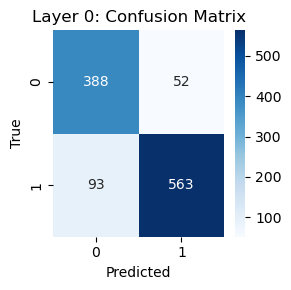


Layer 1:
Best C: 0.464
Train Balanced Accuracy: 0.975
Test Balanced Accuracy: 0.946
Train Weighted F1: 0.973
Test Weighted F1: 0.947
Class distribution:
Class False: 3756 samples
Class True: 6102 samples



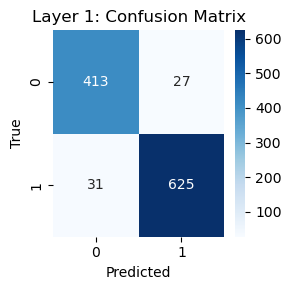

In [37]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["same_half_as_goal"]["Y_train"], X_test, Ys_dict["same_half_as_goal"]["Y_test"])

Layer 0:
Best C: 0.464
Train Balanced Accuracy: 0.819
Test Balanced Accuracy: 0.768
Train Weighted F1: 0.823
Test Weighted F1: 0.786
Class distribution:
Class False: 6584 samples
Class True: 3274 samples



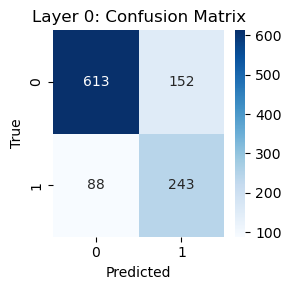


Layer 1:
Best C: 0.100
Train Balanced Accuracy: 0.883
Test Balanced Accuracy: 0.854
Train Weighted F1: 0.883
Test Weighted F1: 0.866
Class distribution:
Class False: 6584 samples
Class True: 3274 samples



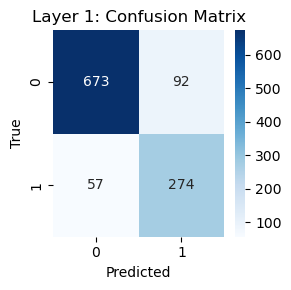

In [38]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["same_quarter_as_goal"]["Y_train"], X_test, Ys_dict["same_quarter_as_goal"]["Y_test"])

Layer 0:
Best C: 0.100
Train Balanced Accuracy: 0.904
Test Balanced Accuracy: 0.870
Train Weighted F1: 0.900
Test Weighted F1: 0.869
Class distribution:
Class 0: 3756 samples
Class 1: 6102 samples



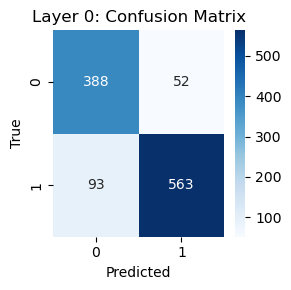


Layer 1:
Best C: 0.464
Train Balanced Accuracy: 0.975
Test Balanced Accuracy: 0.946
Train Weighted F1: 0.973
Test Weighted F1: 0.947
Class distribution:
Class 0: 3756 samples
Class 1: 6102 samples



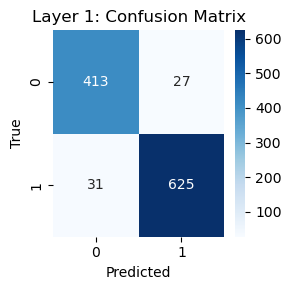

In [39]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["maze_half"]["Y_train"], X_test, Ys_dict["maze_half"]["Y_test"])

Layer 0:
Best C: 0.100
Train Balanced Accuracy: 0.831
Test Balanced Accuracy: 0.751
Train Weighted F1: 0.823
Test Weighted F1: 0.750
Class distribution:
Class 0: 1525 samples
Class 1: 2231 samples
Class 2: 2485 samples
Class 3: 3617 samples



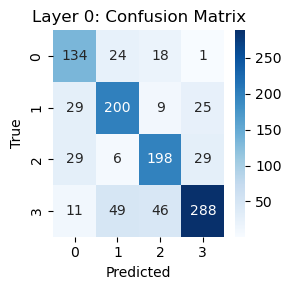


Layer 1:
Best C: 0.100
Train Balanced Accuracy: 0.953
Test Balanced Accuracy: 0.889
Train Weighted F1: 0.949
Test Weighted F1: 0.889
Class distribution:
Class 0: 1525 samples
Class 1: 2231 samples
Class 2: 2485 samples
Class 3: 3617 samples



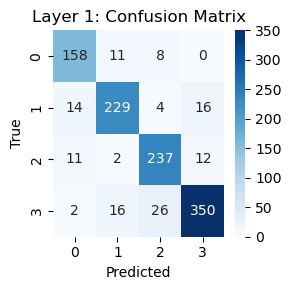

In [40]:
pipeline, test_score = fit_and_evaluate_classification(X_train, Ys_dict["maze_quarter"]["Y_train"], X_test, Ys_dict["maze_quarter"]["Y_test"])